In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from foursquareAPI import get_poi
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv("Parkirisca_do_10_05_2022.csv")
df["Zasedenost"] = df["Kapaciteta"] - df["Prosta mesta"]
df['date'] = pd.to_datetime(df["Datum"], unit="s")
df = df.drop(["Datum", "Prosta (narocniki)", "Oddana (narocniki)",
             "Na voljo (narocniki)", "Cakalna vrsta (narocniki)"], axis=1)
df

,Parkirisce,Prosta mesta,Kapaciteta,Zasedenost,date
0,Bezigrad,58,64,6,2022-02-24 19:13:21
1,Center Stozice,142,509,367,2022-02-24 19:13:21
2,Dolenjska cesta (Strelisce),50,67,17,2022-02-24 19:13:21
3,Gosarjeva ulica,16,190,174,2022-02-24 19:13:21
4,Gosarjeva ulica II.,121,115,-6,2022-02-24 19:13:21
...,...,...,...,...,...
292887,SRC Stozice,0,0,0,2022-05-10 06:05:38
292888,Tacen,0,0,0,2022-05-10 06:05:38
292889,Bratislavska,0,0,0,2022-05-10 06:05:38
292890,BS4/ I,63,80,17,2022-05-10 06:05:38


In [3]:
def copy_and_impute(parking):
    # Prepare new data frame, which will be synced (freqeuncy is exactly 10 mins)
    parking_sync = parking.asfreq("10 min")

    # Copy data before hole 1
    hole_start_date1 = pd.to_datetime("2022-03-15 08:25:12", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iterrows()):
        if index > hole_start_date1:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute first hole
    hole_end_date1 = pd.to_datetime("2022-03-23 07:02:59", format='%Y-%m-%d %H:%M:%S')
    num_rows_imputed = 0
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date1:
            continue
        if index_sync >= hole_end_date1:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy data after hole 1, before hole 2
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date1:
            continue
        if index >= hole_start_date2:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute second hole
    hole_end_date2 = pd.to_datetime("2022-04-22 08:11:54", format='%Y-%m-%d %H:%M:%S')
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date2:
            continue
        if index_sync > hole_end_date2:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy the remaning data
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date2:
            continue
        row_sync["Zasedenost"] = row["Zasedenost"]

    parking_sync = parking_sync["Zasedenost"].fillna(method="bfill")  # Fill remaning spaces with previous values
    parking_sync.dropna(axis=0, inplace=True)  # Remove the somehow remaning NaN rows

    return parking_sync

In [4]:
parkings = {}
for name, group in df.groupby("Parkirisce"):
    name = str(name)
    parking = group

    parking = parking.set_index('date')
    parking = parking.drop(["Parkirisce", "Prosta mesta"], axis=1)

    capacity = 0
    for _, row in parking.iterrows():
        if row["Kapaciteta"] != 0:
            capacity = row["Kapaciteta"]
            break

    raidus = 50
    points_of_interest = get_poi(name, radius=raidus)

    # Filter empty data (10 parkings)
    if (parking["Zasedenost"] == 0).all() or (parking["Zasedenost"] == capacity).all() or points_of_interest is None:
        continue

    parking_sync = pd.DataFrame(copy_and_impute(parking))
    parking_sync["Kapaciteta"] = [capacity for _ in range(len(parking_sync.index))]
    parking_sync["Procent_zasedenosti"] = parking_sync["Zasedenost"] / parking_sync["Kapaciteta"]

    # Add points of interest to the specific column (0: not present, radius-distance: point of interest score) -> POIs are weighted
    restaurant_dist = []
    art_dist = []
    coffee_dist = []
    bar_dist = []
    for distance, poi in points_of_interest:
        if "Restaurant" in poi:
            restaurant_dist.append(distance)
        elif "Art" in poi or "Museum" in poi:
            art_dist.append(distance)
        elif "Coffee" in poi or "Café" in poi or "Cafeteria" in poi:
            coffee_dist.append(distance)
        elif "Bar" in poi:
            bar_dist.append(distance)
    
    restaurant_score = 0 if not restaurant_dist else raidus + 1 - sum(restaurant_dist) / len(restaurant_dist)
    art_score = 0 if not art_dist else raidus + 1 - sum(art_dist) / len(art_dist)
    coffee_score = 0 if not coffee_dist else raidus + 1 - sum(coffee_dist) / len(coffee_dist)
    bar_score = 0 if not bar_dist else raidus + 1 - sum(bar_dist) / len(bar_dist)
    
    parking_sync["Restaurant_score"] = [restaurant_score for _ in range(len(parking_sync.index))]
    parking_sync["Art_score"] = [art_score for _ in range(len(parking_sync.index))]
    parking_sync["Coffee_score"] = [coffee_score for _ in range(len(parking_sync.index))]
    parking_sync["Bar_score"] = [bar_score for _ in range(len(parking_sync.index))]

    # # Print entire dataframe
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     print(parking_sync)

    parkings[name] = parking_sync  # Save the synced data frame to dict

    # plt.plot(parking_sync["Zasedenost"])
    # plt.gcf().autofmt_xdate()
    # plt.xlabel("Datum")
    # plt.ylabel("Stevilo zasedenih mest")
    # plt.title(f"Parkirisce: {name}")
    # plt.show()

print(parkings)

{'BS4/ I':                      Zasedenost  Kapaciteta  Procent_zasedenosti  \
date                                                               
2022-03-04 09:31:53         0.0          80               0.0000   
2022-03-04 09:41:53         0.0          80               0.0000   
2022-03-04 09:51:53         0.0          80               0.0000   
2022-03-04 10:01:53         0.0          80               0.0000   
2022-03-04 10:11:53         0.0          80               0.0000   
...                         ...         ...                  ...   
2022-05-10 03:51:53        17.0          80               0.2125   
2022-05-10 04:01:53        16.0          80               0.2000   
2022-05-10 04:11:53        15.0          80               0.1875   
2022-05-10 04:21:53        16.0          80               0.2000   
2022-05-10 04:31:53        17.0          80               0.2125   

                     Restaurant_score  Art_score  Coffee_score  Bar_score  
date                        

In [5]:
# PARK GROUPS -> USELESS
weekend_off = ("BS4/ I", "BS4/ II", "Bezigrad", "Kranjceva ulica", "Metelkova ulica", "Mirje",
               "Povsetova ulica", "Gosarjeva ulica", "Gosarjeva ulica II.", "Gospodarsko razstavisce", "Linhartova")
# weekend_busy = ("Dolenjska cesta (Strelisce)", "Pokopalisce Polje")
# constant_traffic = ("Kozolec", "NUK II.", "PH Kolezija", "PH Kongresni trg", "Petkovskovo nabrezje II.", "Senatorij Emona", "Slovenceva ulica",
#                     "Tivoli I.", "Tivoli II.", "Trg mladinskih delovnih brigad", "Trg prekomorskih brigad", "Zale I.", "Zale II.", "Zale III.", "Zale IV.", "Zale V.")

weekend_off_matrix = pd.DataFrame(columns=["Parkirisce", "Date", "Zasedenost",
                                  "Kapaciteta", "Procent_zasedenosti",  "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
# weekend_busy_matrix = pd.DataFrame(columns=["Parkirisce", "Date", "Zasedenost",
#                                    "Kapaciteta", "Procent_zasedenosti", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
# constant_traffic_matrix = pd.DataFrame(
#     columns=["Parkirisce", "Date", "Zasedenost", "Kapaciteta", "Procent_zasedenosti", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])

for park_name in weekend_off:
    data = parkings[park_name]
    name_table = [park_name] * len(data.index)
    date_table = data.index.values
    zasedenost_table = data["Zasedenost"].values.astype(int)
    kapaciteta_table = data["Kapaciteta"].values.astype(int)
    procent_table = data["Procent_zasedenosti"].values
    restaurant_score_table = data["Restaurant_score"].values
    art_score_table = data["Art_score"].values
    coffee_score_table = data["Coffee_score"].values
    bar_score_table = data["Bar_score"].values
    df = pd.DataFrame(zip(name_table, date_table, zasedenost_table, kapaciteta_table, procent_table, restaurant_score_table, art_score_table, coffee_score_table, bar_score_table),
                      columns=["Parkirisce", "Date", "Zasedenost", "Kapaciteta", "Procent_zasedenosti", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
    weekend_off_matrix = pd.concat([weekend_off_matrix, df])

# for park_name in weekend_busy:
#     data = parkings[park_name]
#     name_table = [park_name] * len(data.index)
#     date_table = data.index.values
#     zasedenost_table = data["Zasedenost"].values.astype(int)
#     kapaciteta_table = data["Kapaciteta"].values.astype(int)
#     procent_table = data["Procent_zasedenosti"].values
#     restaurant_score_table = data["Restaurant_score"].values
#     art_score_table = data["Art_score"].values
#     coffee_score_table = data["Coffee_score"].values
#     bar_score_table = data["Bar_score"].values
#     df = pd.DataFrame(zip(name_table, date_table, zasedenost_table, kapaciteta_table, procent_table, restaurant_score_table, art_score_table, coffee_score_table, bar_score_table),
#                       columns=["Parkirisce", "Date", "Zasedenost", "Kapaciteta", "Procent_zasedenosti", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
#     weekend_busy_matrix = pd.concat([weekend_busy_matrix, df])

# for park_name in constant_traffic:
#     data = parkings[park_name]
#     name_table = [park_name] * len(data.index)
#     date_table = data.index.values
#     zasedenost_table = data["Zasedenost"].values.astype(int)
#     kapaciteta_table = data["Kapaciteta"].values.astype(int)
#     procent_table = data["Procent_zasedenosti"].values
#     restaurant_score_table = data["Restaurant_score"].values
#     art_score_table = data["Art_score"].values
#     coffee_score_table = data["Coffee_score"].values
#     bar_score_table = data["Bar_score"].values
#     df = pd.DataFrame(zip(name_table, date_table, zasedenost_table, kapaciteta_table, procent_table, restaurant_score_table, art_score_table, coffee_score_table, bar_score_table),
#                       columns=["Parkirisce", "Date", "Zasedenost", "Kapaciteta", "Procent_zasedenosti", "Restaurant_score", "Art_score", "Coffee_score", "Bar_score"])
#     constant_traffic_matrix = pd.concat([constant_traffic_matrix, df])


weekend_off_matrix.set_index(["Parkirisce", "Date"], inplace=True)
# weekend_busy_matrix.set_index(["Parkirisce", "Date"], inplace=True)
# constant_traffic_matrix.set_index(["Parkirisce", "Date"], inplace=True)

weekend_off_matrix = weekend_off_matrix.astype({"Zasedenost": int, "Kapaciteta": int, "Procent_zasedenosti": float,
                                               "Restaurant_score": float,	"Art_score": float,	"Coffee_score": float,	"Bar_score": float})
# weekend_busy_matrix = weekend_busy_matrix.astype({"Zasedenost": int, "Kapaciteta": int, "Procent_zasedenosti": float,
                                                #   "Restaurant_score": float,	"Art_score": float,	"Coffee_score": float,	"Bar_score": float})
# constant_traffic_matrix = constant_traffic_matrix.astype({"Zasedenost": int, "Kapaciteta": int, "Procent_zasedenosti": float,
                                                        #   "Restaurant_score": float,	"Art_score": float,	"Coffee_score": float,	"Bar_score": float})

print(weekend_off_matrix.dtypes)
weekend_off_matrix


Zasedenost               int32
Kapaciteta               int32
Procent_zasedenosti    float64
Restaurant_score       float64
Art_score              float64
Coffee_score           float64
Bar_score              float64
dtype: object


Zasedenost  Kapaciteta  Procent_zasedenosti  \
Parkirisce Date                                                               
BS4/ I     2022-03-04 09:31:53           0          80             0.000000   
           2022-03-04 09:41:53           0          80             0.000000   
           2022-03-04 09:51:53           0          80             0.000000   
           2022-03-04 10:01:53           0          80             0.000000   
           2022-03-04 10:11:53           0          80             0.000000   
...                                    ...         ...                  ...   
Linhartova 2022-05-10 04:33:21         105         121             0.867769   
           2022-05-10 04:43:21         115         121             0.950413   
           2022-05-10 04:53:21         121         121             1.000000   
           2022-05-10 05:03:21         121         121             1.000000   
           2022-05-10 05:13:21         121         121             1.000000   

                                Restaurant_score  Art_score  Coffee_score  \
Parkirisce Date                                                             
BS4/ I     2022-03-04 09:31:53              19.0        0.0           0.0   
           2022-03-04 09:41:53              19.0        0.0           0.0   
           2022-03-04 09:51:53              19.0        0.0           0.0   
           2022-03-04 10:01:53              19.0        0.0           0.0   
           2022-03-04 10:11:53              19.0        0.0           0.0   
...                                          ...        ...           ...   
Linhartova 2022-05-10 04:33:21               0.0        0.0           0.0   
           2022-05-10 04:43:21               0.0        0.0           0.0   
           2022-05-10 04:53:21               0.0        0.0           0.0   
           2022-05-10 05:03:21               0.0        0.0           0.0   
           2022-05-10 05:13:21               0.0        0.0           0.0   

                                Bar_score  
Parkirisce Date                            
BS4/ I     2022-03-04 09:31:53        0.0  
           2022-03-04 09:41:53        0.0  
           2022-03-04 09:51:53        0.0  
           2022-03-04 10:01:53        0.0  
           2022-03-04 10:11:53        0.0  
...                                   ...  
Linhartova 2022-05-10 04:33:21        0.0  
           2022-05-10 04:43:21        0.0  
           2022-05-10 04:53:21        0.0  
           2022-05-10 05:03:21        0.0  
           2022-05-10 05:13:21        0.0  

[115690 rows x 7 columns]

In [6]:
weekend_off_matrix

Zasedenost  Kapaciteta  Procent_zasedenosti  \
Parkirisce Date                                                               
BS4/ I     2022-03-04 09:31:53           0          80             0.000000   
           2022-03-04 09:41:53           0          80             0.000000   
           2022-03-04 09:51:53           0          80             0.000000   
           2022-03-04 10:01:53           0          80             0.000000   
           2022-03-04 10:11:53           0          80             0.000000   
...                                    ...         ...                  ...   
Linhartova 2022-05-10 04:33:21         105         121             0.867769   
           2022-05-10 04:43:21         115         121             0.950413   
           2022-05-10 04:53:21         121         121             1.000000   
           2022-05-10 05:03:21         121         121             1.000000   
           2022-05-10 05:13:21         121         121             1.000000   

                                Restaurant_score  Art_score  Coffee_score  \
Parkirisce Date                                                             
BS4/ I     2022-03-04 09:31:53              19.0        0.0           0.0   
           2022-03-04 09:41:53              19.0        0.0           0.0   
           2022-03-04 09:51:53              19.0        0.0           0.0   
           2022-03-04 10:01:53              19.0        0.0           0.0   
           2022-03-04 10:11:53              19.0        0.0           0.0   
...                                          ...        ...           ...   
Linhartova 2022-05-10 04:33:21               0.0        0.0           0.0   
           2022-05-10 04:43:21               0.0        0.0           0.0   
           2022-05-10 04:53:21               0.0        0.0           0.0   
           2022-05-10 05:03:21               0.0        0.0           0.0   
           2022-05-10 05:13:21               0.0        0.0           0.0   

                                Bar_score  
Parkirisce Date                            
BS4/ I     2022-03-04 09:31:53        0.0  
           2022-03-04 09:41:53        0.0  
           2022-03-04 09:51:53        0.0  
           2022-03-04 10:01:53        0.0  
           2022-03-04 10:11:53        0.0  
...                                   ...  
Linhartova 2022-05-10 04:33:21        0.0  
           2022-05-10 04:43:21        0.0  
           2022-05-10 04:53:21        0.0  
           2022-05-10 05:03:21        0.0  
           2022-05-10 05:13:21        0.0  

[115690 rows x 7 columns]

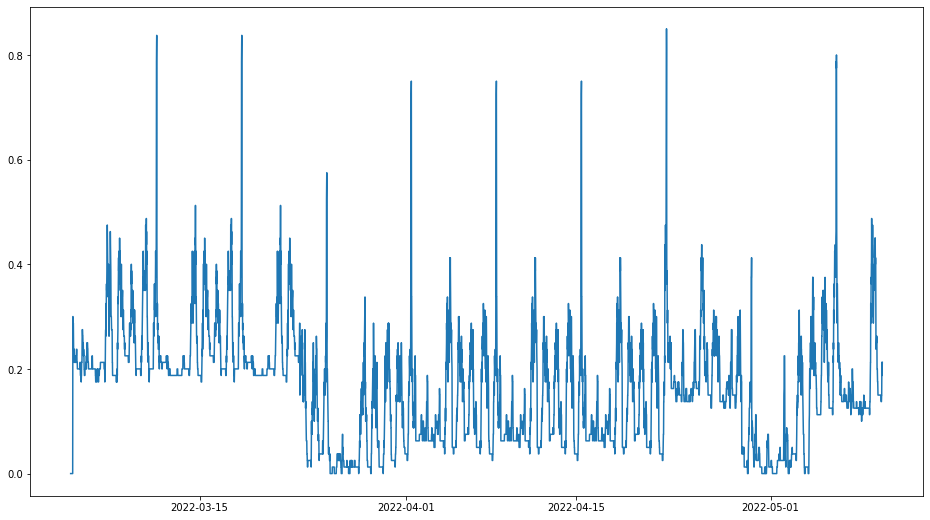

Zasedenost               int32
Kapaciteta               int32
Procent_zasedenosti    float64
Restaurant_score       float64
Art_score              float64
Coffee_score           float64
Bar_score              float64
dtype: object

In [17]:
first_parking_df = weekend_off_matrix.loc[weekend_off_matrix.index.get_level_values(
    "Parkirisce") == weekend_off_matrix.index.get_level_values("Parkirisce")[0]]
first_parking_df.index = first_parking_df.index.get_level_values("Date")

plt.figure(figsize=(16, 9))
plt.plot(first_parking_df["Procent_zasedenosti"])
plt.show()

first_parking_df.dtypes


In [18]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)


In [44]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(first_parking_df[["Procent_zasedenosti", "Restaurant_score", "Art_score","Coffee_score", "Bar_score"]])

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

6444 3175


In [45]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), :])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [46]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [49]:
# trainY
trainX.shape

(6442, 1, 5)

In [35]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))

In [42]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2) # Long
model.fit(trainX, trainY, epochs=2, batch_size=1, verbose=2) # Short

Epoch 1/2


ValueError: in user code:

    File "c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Matija\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_5" (type Sequential).
    
    Input 0 of layer "lstm_5" is incompatible with the layer: expected shape=(None, None, 1), found shape=(1, 1, 7)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(1, 1, 7), dtype=float32)
      • training=True
      • mask=None


In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.02 RMSE
Test Score: 0.02 RMSE


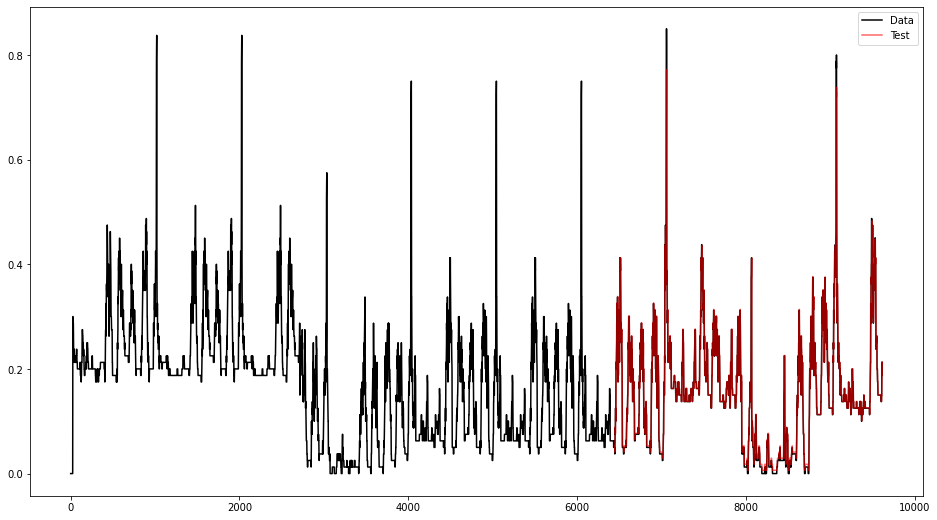

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(16, 9))
plt.plot(scaler.inverse_transform(dataset), "k-", label="Data")
# plt.plot(trainPredictPlot, "b-",label="Train")
plt.plot(testPredictPlot,"r-", label="Test", alpha=0.6)
plt.legend()
plt.show()


In [16]:
# TODO: Use this code to save the model!

# model_path = 'Bidirectional_LSTM_Multivariate.h5'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
# callbacks = [checkpoint]

# Load the saved model
# saved_model = tf.keras.models.load_model(model_path)

# history = lstm_model.fit(train_data, epochs=1, steps_per_epoch=100, validation_data=val_data,
                        #  validation_steps=50, verbose=1, callbacks=callbacks)